# Data

### The data on apartments (size, number of rooms, address, and price) is collected by scraping a local website with apartment listings (willhaben.at). Using geopy we find the coordinates for each district and then using Foursquare we collect the closest venues (supermarket, restaurant, park, etc.). After the data collection we can run k-means clustering to cluster the districts into residential and commercial areas and visualize all the data on a single choropleth map

In [2]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

import re

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Scraping willhaben.at for apartments data in Vienna

In [14]:
listing_found = True
page_num = 1
listings = []

while listing_found:
    
    # define header to make the request look like it's comming from an actual browser
    headers = {'User-agent': 'Googlebot'}
    
    # set url 
    url = 'https://www.willhaben.at/iad/immobilien/mietwohnungen/mietwohnung-angebote?areaId=900&page={}&rows=200'.format(page_num)
    
    # load the response
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # find all outer containers of listings
    apartment_containers = soup.find_all('section', class_="content-section isRealestate")
    
    # check if page contains listings
    if len(apartment_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for apt in apartment_containers:
        try:
            info = apt.find_all('div', class_="info")[0]

            try:
                size = info.find_all('span', class_="desc-left")[0].text.split()[0]
            except:
                size = np.nan

            try:
                rooms = info.find_all('span', class_="desc-left")[0].text.split()[2]
            except:
                rooms = np.nan

            try:
                price = info.find_all('span', class_="pull-right")[0].text.split()[0]
            except:
                price = np.nan

        except:
            size, rooms, price = np.nan

        try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
        except:
            address = None
            postal_code = None
            district = None

        listings.append([postal_code, district, size, rooms, price])
    
    # increase page number
    page_num += 1
    
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))

In [15]:
rental = pd.DataFrame(listings, columns=['PostalCode', 'District', 'Size', 'Rooms', 'Price'])

In [16]:
print('There are {} apartments in the dataset'.format(rental.shape[0]))

There are 11246 apartments in the dataset


In [17]:
rental.head()

,PostalCode,District,Size,Rooms,Price
0,1050,Margareten,40,1,"850,-"
1,1210,Floridsdorf,199,5,"2.691,20"
2,1030,Landstraße,124,4,"1.698,18"
3,1220,Donaustadt,45,NaN,"1.149,-"
4,1060,Mariahilf,51,2,"743,97"


In [25]:
rental.dtypes

PostalCode     object
District       object
Size           object
Rooms          object
Price         float64
dtype: object

In [24]:
rental['Price']=rental['Price'].str.replace('.', '').str.replace(',', '.').str.replace('-', '00').str.replace('vermietet', 'NaN').str.replace('verkauft','Nan').astype(np.float64)


AttributeError: Can only use .str accessor with string values!

In [26]:
rental['Size'] = rental['Size'].str.replace('–', 'NaN').astype('float')
rental['Rooms'] = rental['Rooms'].astype('float')

In [27]:
rental.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
dtype: object

# Pre-process & Visualize the data

#### calculate price per M2

In [28]:
rental['Price/m2'] = (rental['Price']/rental['Size']).round(2)
rental.head()

,PostalCode,District,Size,Rooms,Price,Price/m2
0,1050,Margareten,40.0,1.0,850.00,21.25
1,1210,Floridsdorf,199.0,5.0,2691.20,13.52
2,1030,Landstraße,124.0,4.0,1698.18,13.70
3,1220,Donaustadt,45.0,NaN,1149.00,25.53
4,1060,Mariahilf,51.0,2.0,743.97,14.59


#### Remove rows with NA values in Postalcode,District,Size and Price

In [29]:
rental.dropna(subset=['PostalCode', 'District', 'Size', 'Price'], inplace=True)
rental.shape

(11190, 6)

## visualize number of appartments in each district and plot the price

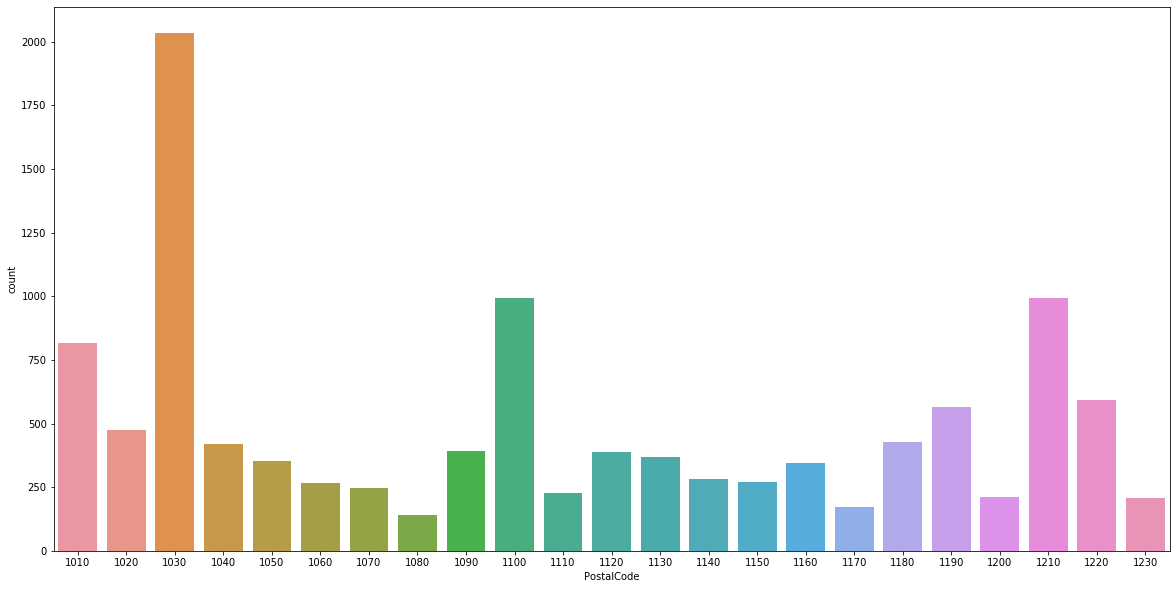

In [31]:
plt.figure(figsize=(20,10))
sns.countplot(rental['PostalCode'])

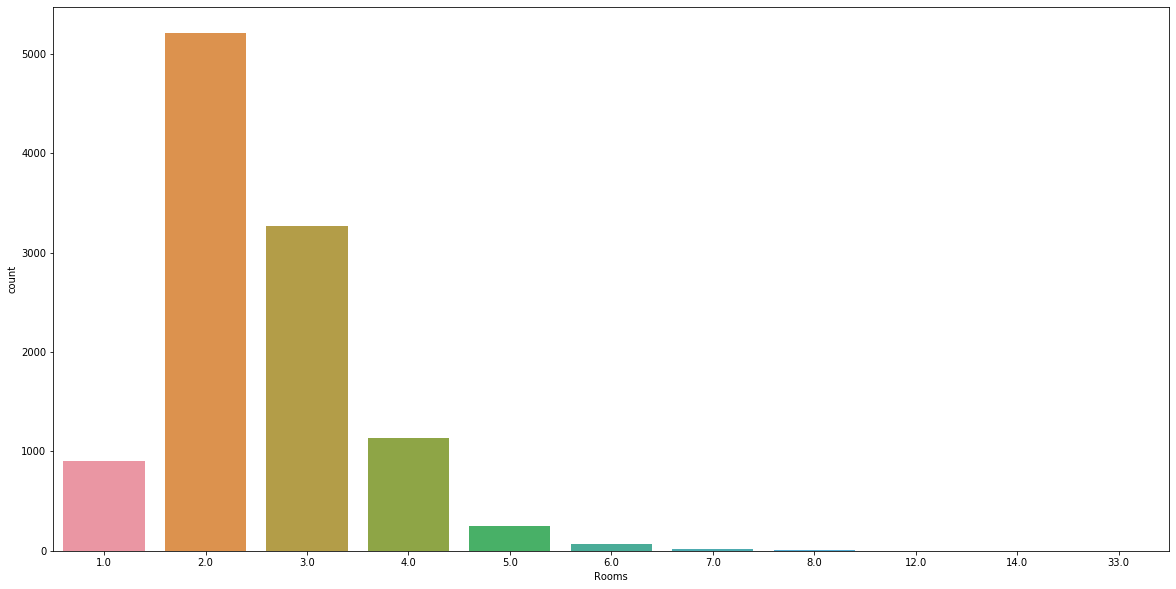

In [36]:
plt.figure(figsize=(20,10))
sns.countplot(rental['Rooms'])

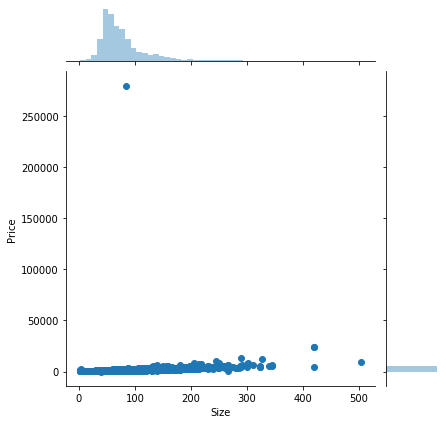

In [32]:
sns.jointplot(x='Size', y='Price', data=rental)

#### remove appartments with price higher than 5000 EUR

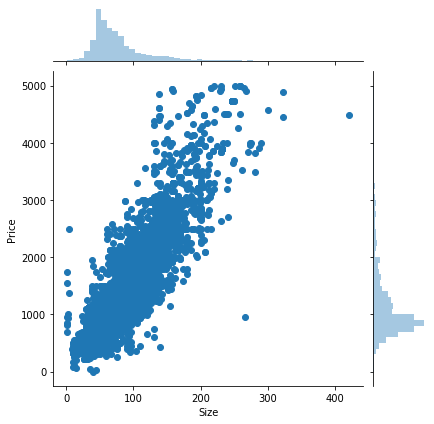

In [35]:
rental = rental[rental['Price'] <= 5000]
sns.jointplot(x='Size',y='Price',data=rental)

### In the following plot we can see that the price/m2 in different district of Vienna


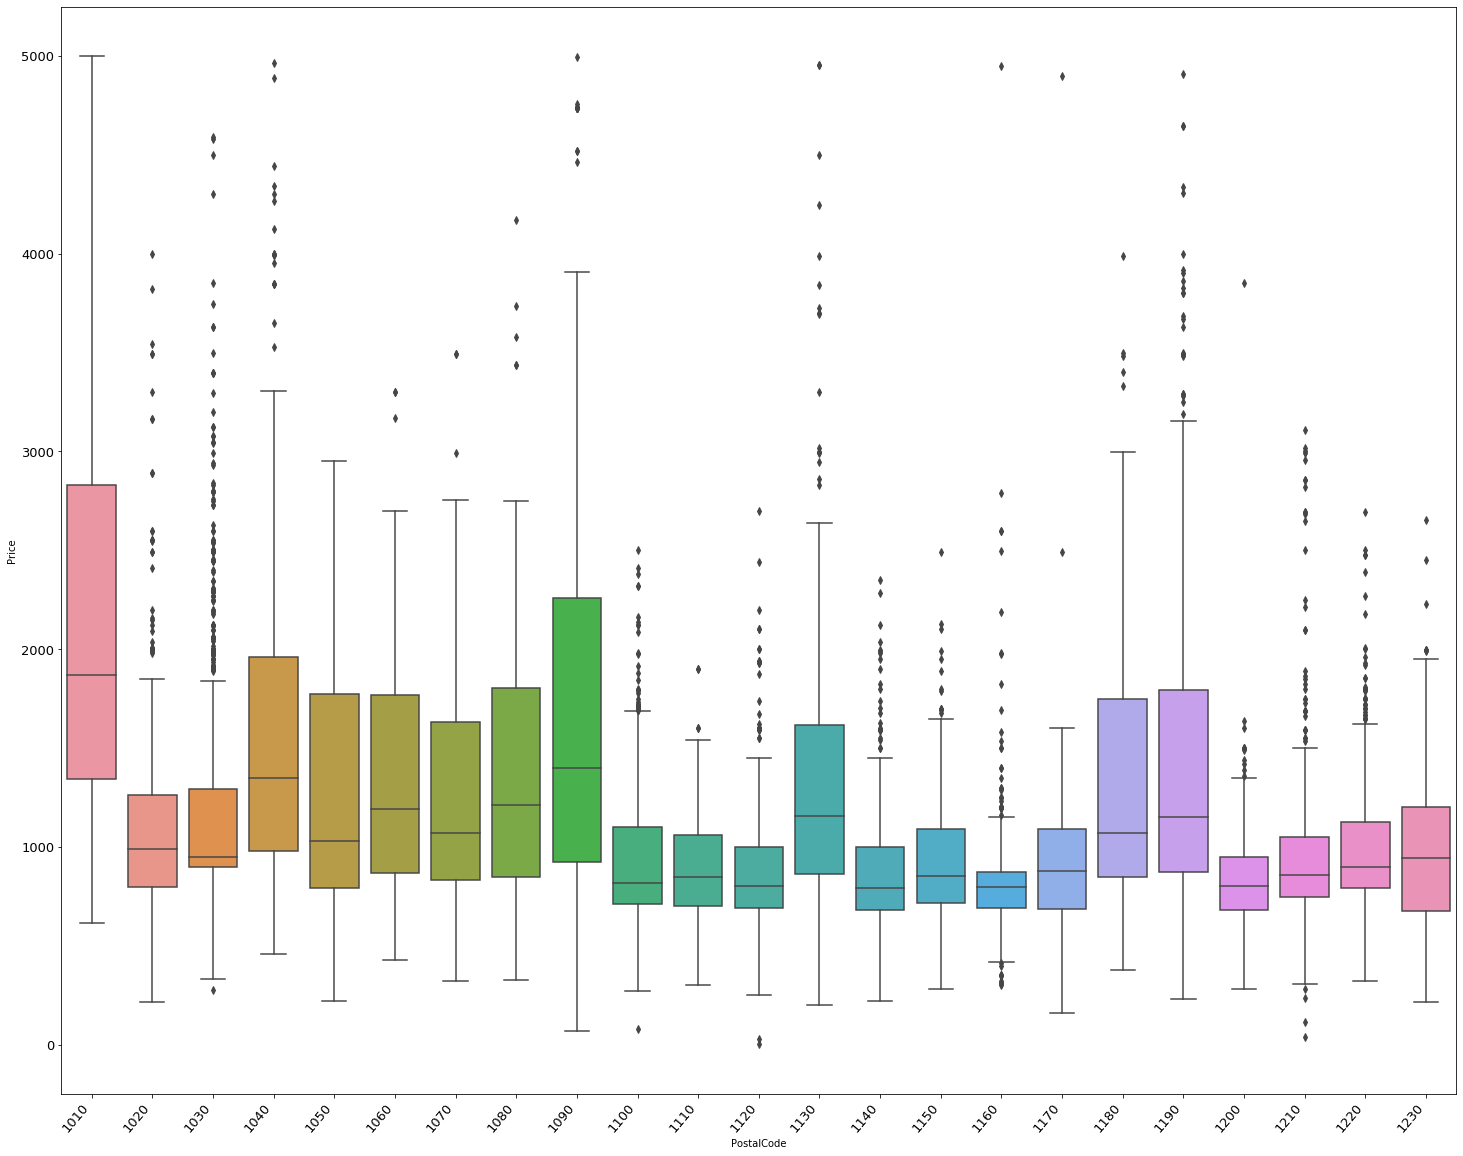

In [43]:
plt.figure(figsize=(25,20))
ax = sns.boxplot(x='PostalCode', y='Price', data=rental)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

# Get coordinates for each district¶


### To avoid fetching coordinates for the same districts many times, we find the unique postal codes and find the coordinates once for each district

In [44]:
vienna_districts = rental[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
vienna_districts

,PostalCode,District
0,1010,Innere Stadt
1,1020,Leopoldstadt
2,1030,Landstraße
3,1040,Wieden
4,1050,Margareten
5,1060,Mariahilf
6,1070,Neubau
7,1080,Josefstadt
8,1090,Alsergrund
9,1100,Favoriten


In [45]:
latitude = np.zeros(vienna_districts.shape[0])
longitude = np.zeros(vienna_districts.shape[0])

geolocator = Nominatim(user_agent="vienna_explorer")

for idx in range(vienna_districts.shape[0]):
    address = vienna_districts['District'].loc[idx] + ', Wien'
    
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude

In [46]:
district_coordinates = vienna_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

,PostalCode,District,Latitude,Longitude
0,1010,Innere Stadt,48.209133,16.369992
1,1020,Leopoldstadt,48.200638,16.426895
2,1030,Landstraße,48.193644,16.396286
3,1040,Wieden,48.208354,16.372504
4,1050,Margareten,48.188073,16.353386
5,1060,Mariahilf,48.195475,16.347023
6,1070,Neubau,48.201881,16.349056
7,1080,Josefstadt,48.210598,16.351750
8,1090,Alsergrund,48.225073,16.358398
9,1100,Favoriten,48.173423,16.377914


### visualize the districts on a map

In [53]:
# create map of Vienna using latitude and longitude values
map_vienna = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vienna)  
    
map_vienna

# Visualize the average price/m2 per district on a choropleth map

In [57]:
import urllib, json
url = "https://github.com/ginseng666/GeoJSON-TopoJSON-Austria/raw/master/2017/special/gemeinden_wien_bezirke_geo.json"
response = urllib.request.urlopen(url)
location_data = json.loads(response.read())

In [58]:
location_data['features'] = location_data['features'][:23]

In [59]:
for idx in range(len(location_data['features'])):
    location_data['features'][idx]['properties']['name'] = location_data['features'][idx]['properties']['name'].replace('Wien ','')

### Calculate the mean per district

In [61]:
mean_per_district = rental.groupby('District').mean().reset_index()
mean_per_district

,District,Size,Rooms,Price,Price/m2
0,Alsergrund,100.549872,2.966234,1716.407801,18.071841
1,Brigittenau,61.295775,2.169903,855.995587,14.541315
2,Donaustadt,62.683502,2.369983,991.039646,16.395253
3,Döbling,87.914132,2.785321,1449.608927,16.777835
4,Favoriten,59.578629,2.348339,912.043659,15.782127
5,Floridsdorf,64.300503,2.483249,926.680834,15.142171
6,Hernals,68.684211,2.371069,924.475439,13.967778
7,Hietzing,90.926431,2.886740,1356.766131,15.034986
8,Innere Stadt,109.599490,2.824607,2152.515383,21.103546
9,Josefstadt,91.921429,2.910448,1414.581000,18.921929


In [64]:
vienna_geo = location_data
plt.figure(figsize=(30,20))
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

vienna_map

<Figure size 2160x1440 with 0 Axes>

# Get Foursquare data

In [65]:
CLIENT_ID = 'CMMOWFY3NUDIMWQJZ5RCDQ5XPIHZQOGMBVI20RJAGIX3UAJN'
CLIENT_SECRET = 'XSX2J1KYKZ51DLUASURX0CVLTFJJA20E4203XSUDIILYJKRI'
VERSION = '20180605'

In [66]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [67]:
vienna_venues = getNearbyVenues(names=district_coordinates['District'],
                                   latitudes=district_coordinates['Latitude'],
                                   longitudes=district_coordinates['Longitude'],
                                   radius=2000, LIMIT=100)

In [68]:
vienna_venues

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.209133,16.369992,Stephansplatz,48.208299,16.371880,Plaza
1,Innere Stadt,48.209133,16.369992,Stephansdom,48.208626,16.372672,Church
2,Innere Stadt,48.209133,16.369992,Park Hyatt Vienna,48.210691,16.367788,Hotel
3,Innere Stadt,48.209133,16.369992,Kolar,48.210538,16.370033,Gastropub
4,Innere Stadt,48.209133,16.369992,COS,48.209359,16.371591,Clothing Store
...,...,...,...,...,...,...,...
1769,Liesing,48.141106,16.293912,SZIHN Siebenhirten,48.129587,16.310124,Bakery
1770,Liesing,48.141106,16.293912,Kristall-Apotheke,48.127787,16.307637,Pharmacy
1771,Liesing,48.141106,16.293912,SPAR,48.136782,16.317670,Supermarket
1772,Liesing,48.141106,16.293912,Woktime,48.137629,16.318534,Asian Restaurant


In [69]:
vienna_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Alsergrund,100,100,100,100,100,100
Brigittenau,100,100,100,100,100,100
Donaustadt,30,30,30,30,30,30
Döbling,61,61,61,61,61,61
Favoriten,100,100,100,100,100,100
Floridsdorf,46,46,46,46,46,46
Hernals,29,29,29,29,29,29
Hietzing,27,27,27,27,27,27
Innere Stadt,100,100,100,100,100,100


In [73]:
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")
vienna_onehot.insert(loc=0,column='District', value=vienna_venues['District'] )
vienna_onehot.head()

,District,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
vienna_grouped = vienna_onehot.groupby('District').mean().reset_index()
vienna_grouped

,District,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Alsergrund,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.01,0.000000,0.010000,0.000000,0.000000,0.00,0.00,0.000000
1,Brigittenau,0.00,0.00,0.00,0.00,0.00,0.000000,0.020000,0.000000,0.00,...,0.010000,0.00,0.00,0.000000,0.000000,0.010000,0.020000,0.00,0.00,0.000000
2,Donaustadt,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
3,Döbling,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.016393,0.081967,0.000000,0.000000,0.00,0.00,0.016393
4,Favoriten,0.00,0.00,0.00,0.03,0.00,0.000000,0.050000,0.000000,0.00,...,0.020000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
5,Floridsdorf,0.00,0.00,0.00,0.00,0.00,0.000000,0.021739,0.021739,0.00,...,0.000000,0.00,0.00,0.021739,0.021739,0.021739,0.000000,0.00,0.00,0.000000
6,Hernals,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
7,Hietzing,0.00,0.00,0.00,0.00,0.00,0.000000,0.074074,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
8,Innere Stadt,0.01,0.01,0.00,0.00,0.02,0.000000,0.000000,0.000000,0.01,...,0.000000,0.01,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
9,Josefstadt,0.00,0.01,0.01,0.00,0.03,0.000000,0.020000,0.000000,0.00,...,0.000000,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000


In [75]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [78]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = vienna_grouped['District']

for ind in np.arange(vienna_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vienna_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Café,Restaurant,Coffee Shop,Park,Hotel,Pizza Place,Italian Restaurant,Pub,Bar,BBQ Joint
1,Brigittenau,Supermarket,Austrian Restaurant,Plaza,Italian Restaurant,Park,Restaurant,Bakery,Ice Cream Shop,Hotel,Gym
2,Donaustadt,Supermarket,Bakery,Bus Stop,Fast Food Restaurant,Metro Station,Gastropub,Convenience Store,Breakfast Spot,Soccer Field,Pizza Place
3,Döbling,Restaurant,Austrian Restaurant,Café,Wine Bar,Italian Restaurant,Bus Stop,Scenic Lookout,Supermarket,Bakery,Mountain
4,Favoriten,Hotel,Restaurant,Asian Restaurant,Supermarket,Café,Park,Bar,Austrian Restaurant,Grocery Store,Art Gallery


## Making Clusters for Neighborhood

In [79]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

vienna_grouped_clustering = vienna_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 0, 4, 2, 2, 4, 3, 1, 1])

In [ ]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [84]:
# add price/m2 for each district
vienna_merged = pd.merge(district_coordinates, mean_per_district[['District', 'Price/m2']])

# add latitude/longitude for each district
vienna_merged = vienna_merged.join(district_venues_sorted.set_index('District'), on='District')

vienna_merged

,PostalCode,District,Latitude,Longitude,Price/m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,Innere Stadt,48.209133,16.369992,21.103546,1,Plaza,Restaurant,Hotel,Austrian Restaurant,Café,Bar,Museum,Park,Ice Cream Shop,Italian Restaurant
1,1020,Leopoldstadt,48.200638,16.426895,16.084777,2,Restaurant,Supermarket,Hotel,Café,Austrian Restaurant,Bakery,Gym / Fitness Center,Plaza,Beer Garden,Bar
2,1030,Landstraße,48.193644,16.396286,17.305839,1,Hotel,Austrian Restaurant,Restaurant,Concert Hall,Café,Steakhouse,Asian Restaurant,Bakery,Pizza Place,Italian Restaurant
3,1040,Wieden,48.208354,16.372504,16.387821,1,Restaurant,Austrian Restaurant,Plaza,Hotel,Bar,Café,Ice Cream Shop,Italian Restaurant,Park,Museum
4,1050,Margareten,48.188073,16.353386,18.827054,1,Austrian Restaurant,Hotel,Bar,Café,Restaurant,Ice Cream Shop,Coffee Shop,Asian Restaurant,Pizza Place,Bistro
5,1060,Mariahilf,48.195475,16.347023,17.616491,1,Austrian Restaurant,Ice Cream Shop,Hotel,Café,Coffee Shop,Pizza Place,Bar,Vietnamese Restaurant,Plaza,Burger Joint
6,1070,Neubau,48.201881,16.349056,16.139190,1,Ice Cream Shop,Coffee Shop,Hotel,Italian Restaurant,Bar,Austrian Restaurant,Plaza,Café,Gym / Fitness Center,Museum
7,1080,Josefstadt,48.210598,16.351750,18.921929,1,Plaza,Hotel,Café,Ice Cream Shop,Coffee Shop,Bar,Park,Italian Restaurant,Art Museum,Restaurant
8,1090,Alsergrund,48.225073,16.358398,18.071841,1,Café,Restaurant,Coffee Shop,Park,Hotel,Pizza Place,Italian Restaurant,Pub,Bar,BBQ Joint
9,1100,Favoriten,48.173423,16.377914,15.782127,2,Hotel,Restaurant,Asian Restaurant,Supermarket,Café,Park,Bar,Austrian Restaurant,Grocery Store,Art Gallery


# visualize the resulting clusters

In [91]:
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vienna_merged['Latitude'], vienna_merged['Longitude'], vienna_merged['District'], vienna_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters